In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Data Processing 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Data Shuffling (if required)
from sklearn.utils import shuffle

# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) 
simplefilter(action='ignore', category=UserWarning) 
pd.options.mode.chained_assignment = None  # default='warn'

# Mathematical Calculations
from math import radians, cos, sin, asin, sqrt

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Distance Calculations between two point/places on earth
from haversine import haversine, Unit

# Satistical Testing
from scipy import stats
from scipy.stats import spearmanr

# Converting Categorical to Numerical Finite Values
from sklearn.preprocessing import LabelEncoder

# Model Designing and Evaluation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import roc_auc_score
#from sklearn.ensemble import StackingRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
print ('The Pacific Time',time.strftime("%H:%M:%S"))
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The Pacific Time 19:34:19
/kaggle/input/aapl10y/AAPL10Y.csv


__Make sure you restart the Python kernel after executing the `pip install` command below__! After you restart the kernel you don't have to execute the command again.

# Building an ARIMA Model for a Financial Dataset

In this notebook, you will build an ARIMA model for AAPL stock closing prices. The lab objectives are:

* Pull data from Google Cloud Storage into a Pandas dataframe
* Learn how to prepare raw stock closing data for an ARIMA model
* Apply the Dickey-Fuller test 
* Build an ARIMA model using the statsmodels library

In [2]:
#!pip install --user statsmodels

In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Cloud Storage

In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe. We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index. 

In [4]:
df = pd.read_csv('/kaggle/input/aapl10y/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.13570,140628992.00000,20.00000,20.15860,19.86710
2009-06-04,20.53430,136628071.00000,20.01860,20.59710,20.00570
2009-06-05,20.66710,157944127.00000,20.75860,20.91430,20.45860
2009-06-08,20.55000,232466290.00000,20.54570,20.60430,19.91860
2009-06-09,20.38860,168830811.00000,20.54430,20.65140,20.07860


## Prepare data for ARIMA 

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis. 

In [5]:
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

,close
date,
2009-06-07,20.44570
2009-06-14,20.10686
2009-06-21,19.52514
2009-06-28,19.71144
2009-07-05,20.25893


Let's create a column for weekly returns. Take the log to of the returns to normalize large fluctuations.

In [6]:
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-07,20.44570,NaN
2009-06-14,20.10686,-0.01671
2009-06-21,19.52514,-0.02936
2009-06-28,19.71144,0.00950
2009-07-05,20.25893,0.02740


In [7]:
# drop null rows
df_week.dropna(inplace=True)

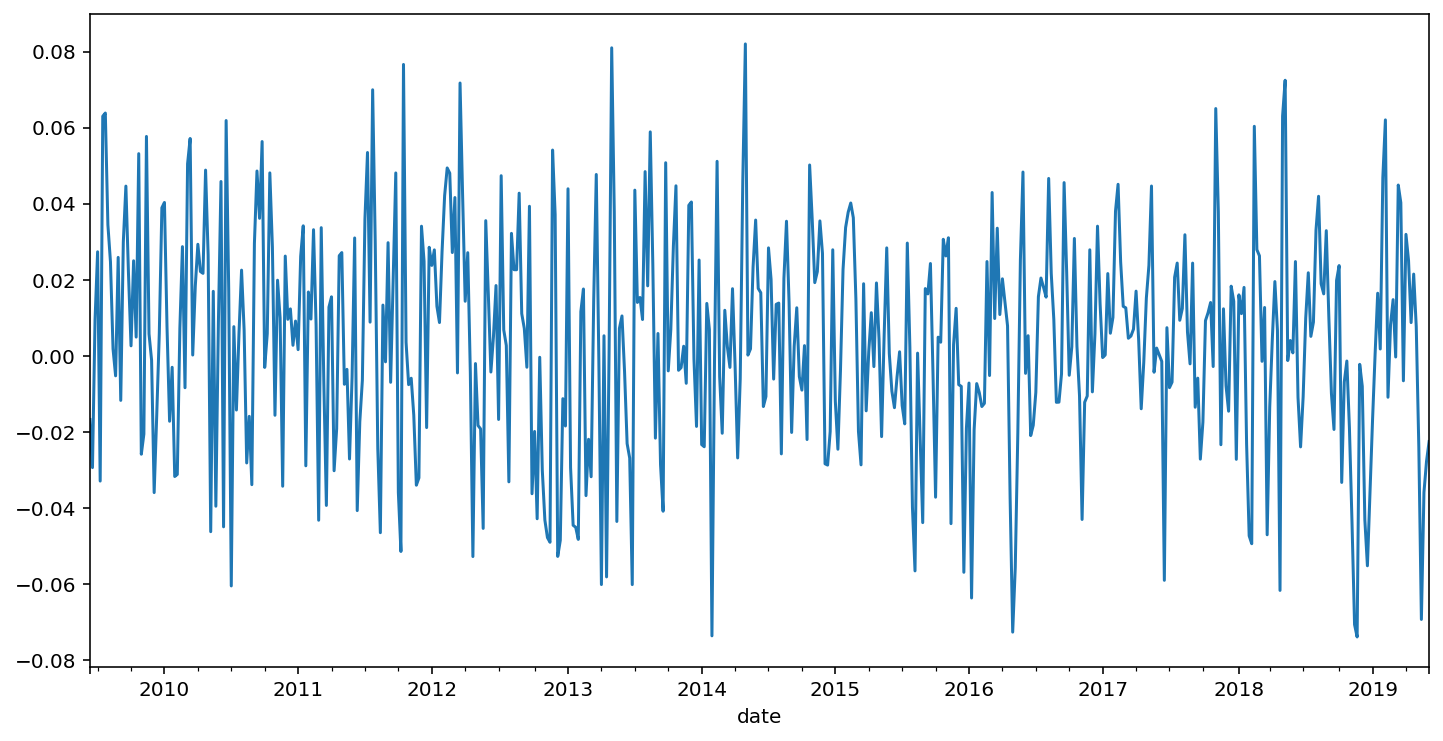

In [8]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [9]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-14,-0.01671
2009-06-21,-0.02936
2009-06-28,0.00950
2009-07-05,0.02740
2009-07-12,-0.03290


## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [11]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

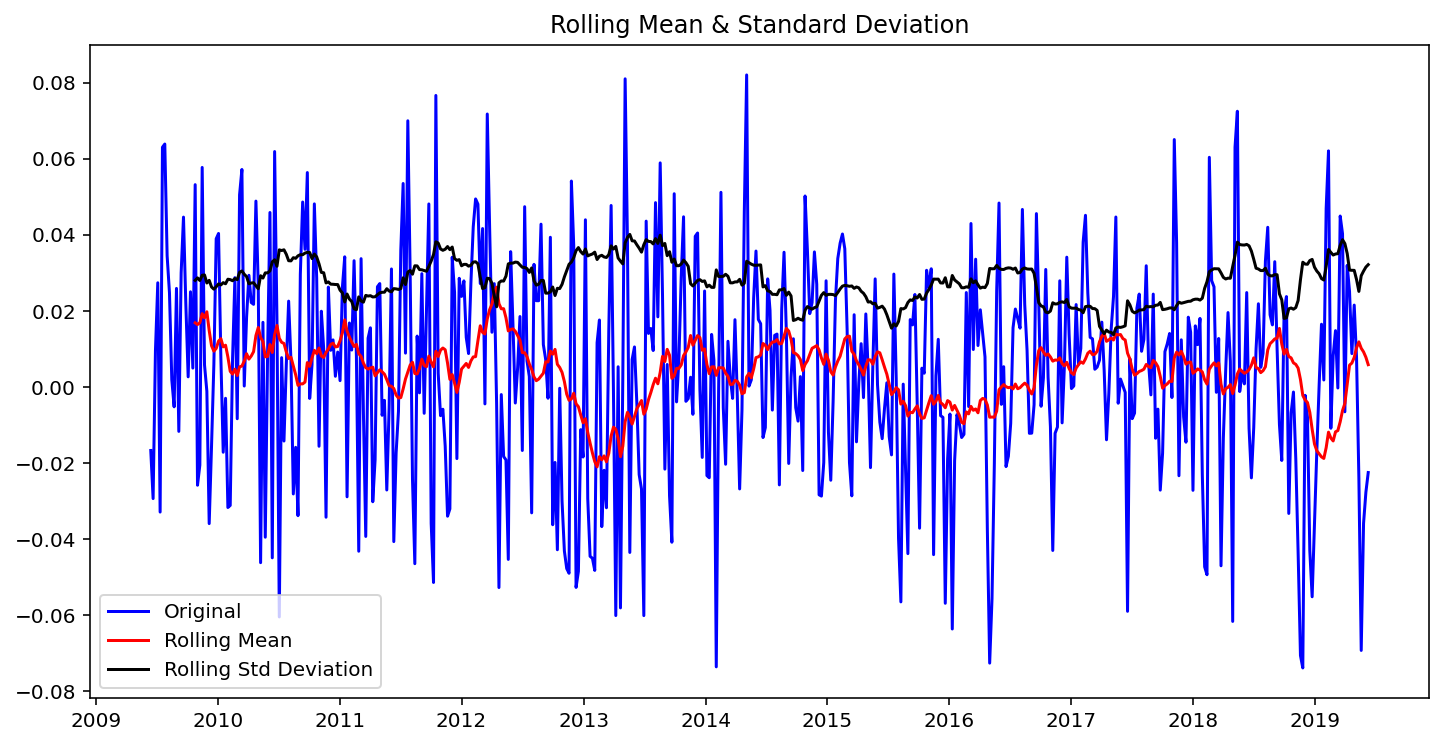

In [12]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [13]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -11.05002
p-value                         0.00000
#Lags Used                      2.00000
Number of Observations Used   519.00000
Critical Value (1%)            -3.44301
Critical Value (5%)            -2.86712
Critical Value (10%)           -2.56974
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

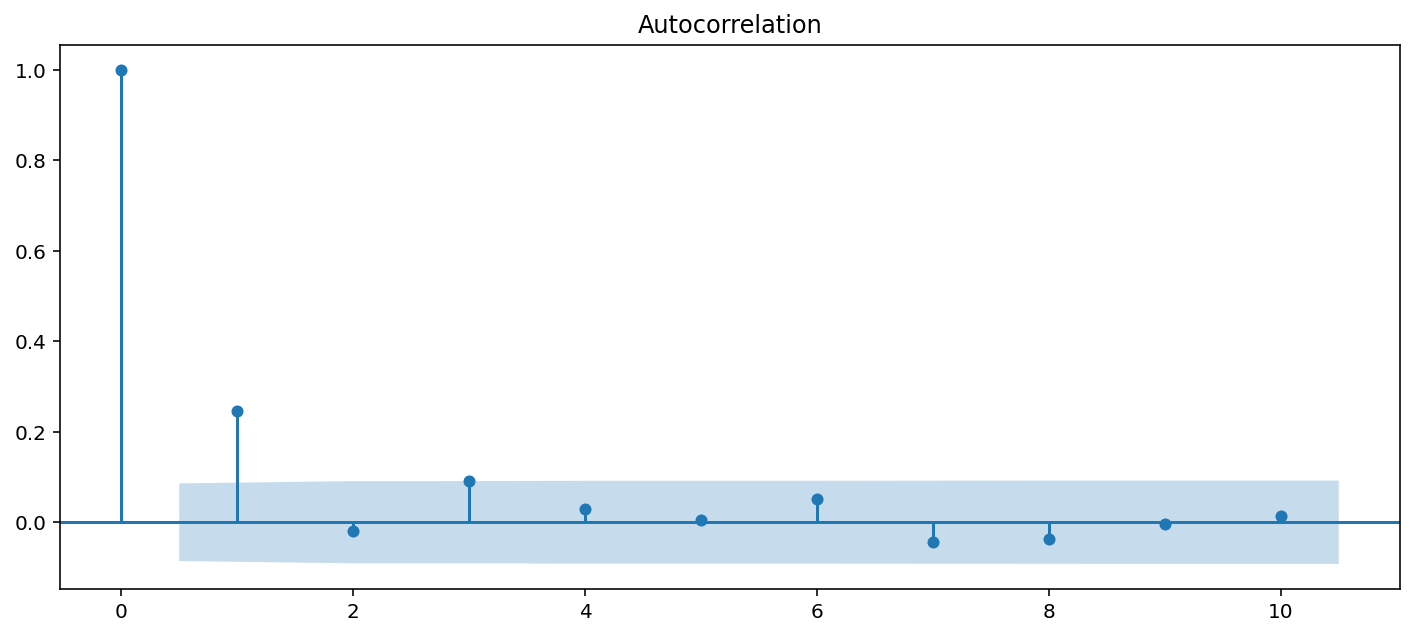

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

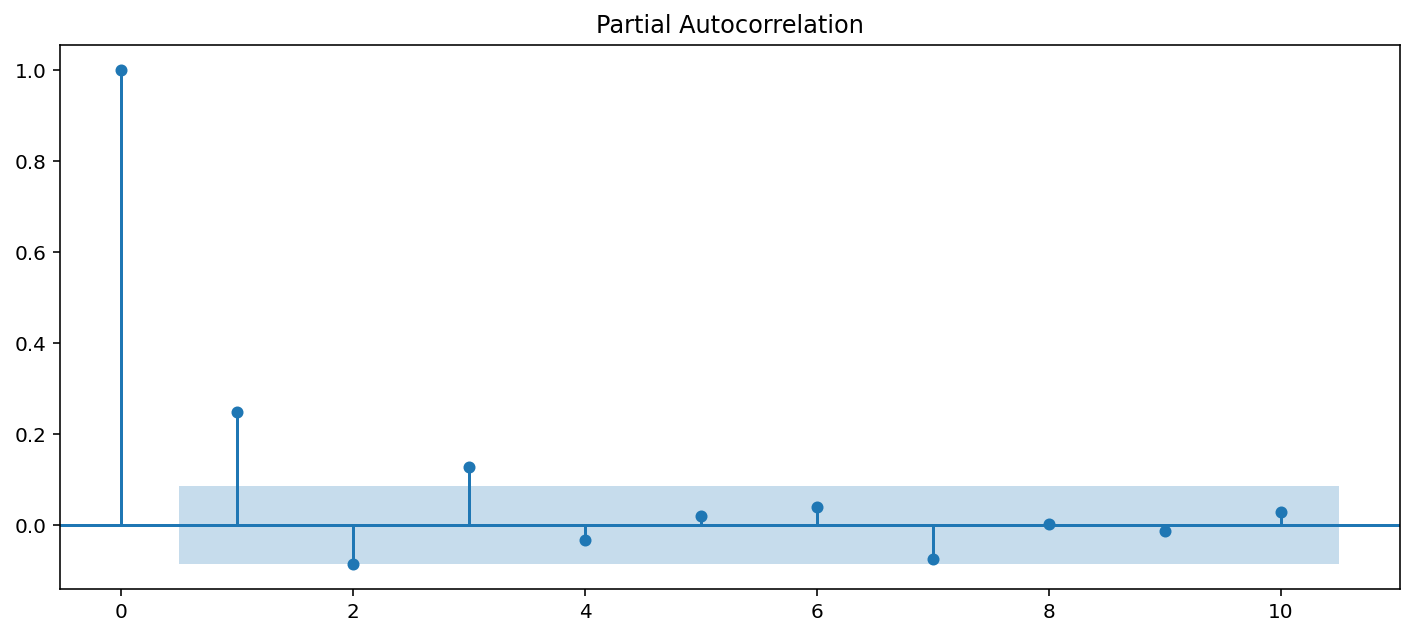

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

<img src="../imgs/How_to_Read_PACF_ACF.jpg" alt="drawing" width="300" height="300"/>

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [16]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (3, 1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                     ARMA(3, 1)   Log Likelihood                1131.581
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 05 Sep 2021   AIC                          -2251.163
Time:                        19:34:24   BIC                          -2225.617
Sample:                             0   HQIC                         -2241.157
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.442      0.015       0.001       0.007
ar.L1.y        0.0601      0.264      0.227      0.820      -0.458       0.578
ar.L2.y       -0.0591      0.084     -0.705      0.481      -0.223       0.105
ar.L3.y        0.1080      0.053      2.049      0.040       0.005       0.211
ma.L1.y        0.2219      0.265      0.839      0.401      -0.297       0.740
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8278           -1.8757j            2.0502           -0.3161
AR.2           -0.8278           +1.8757j            2.0502            0.3161
AR.3            2.2031           -0.0000j            2.2031           -0.0000
MA.1           -4.5055           +0.0000j            4.5055            0.5000
-----------------------------------------------------------------------------
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys).

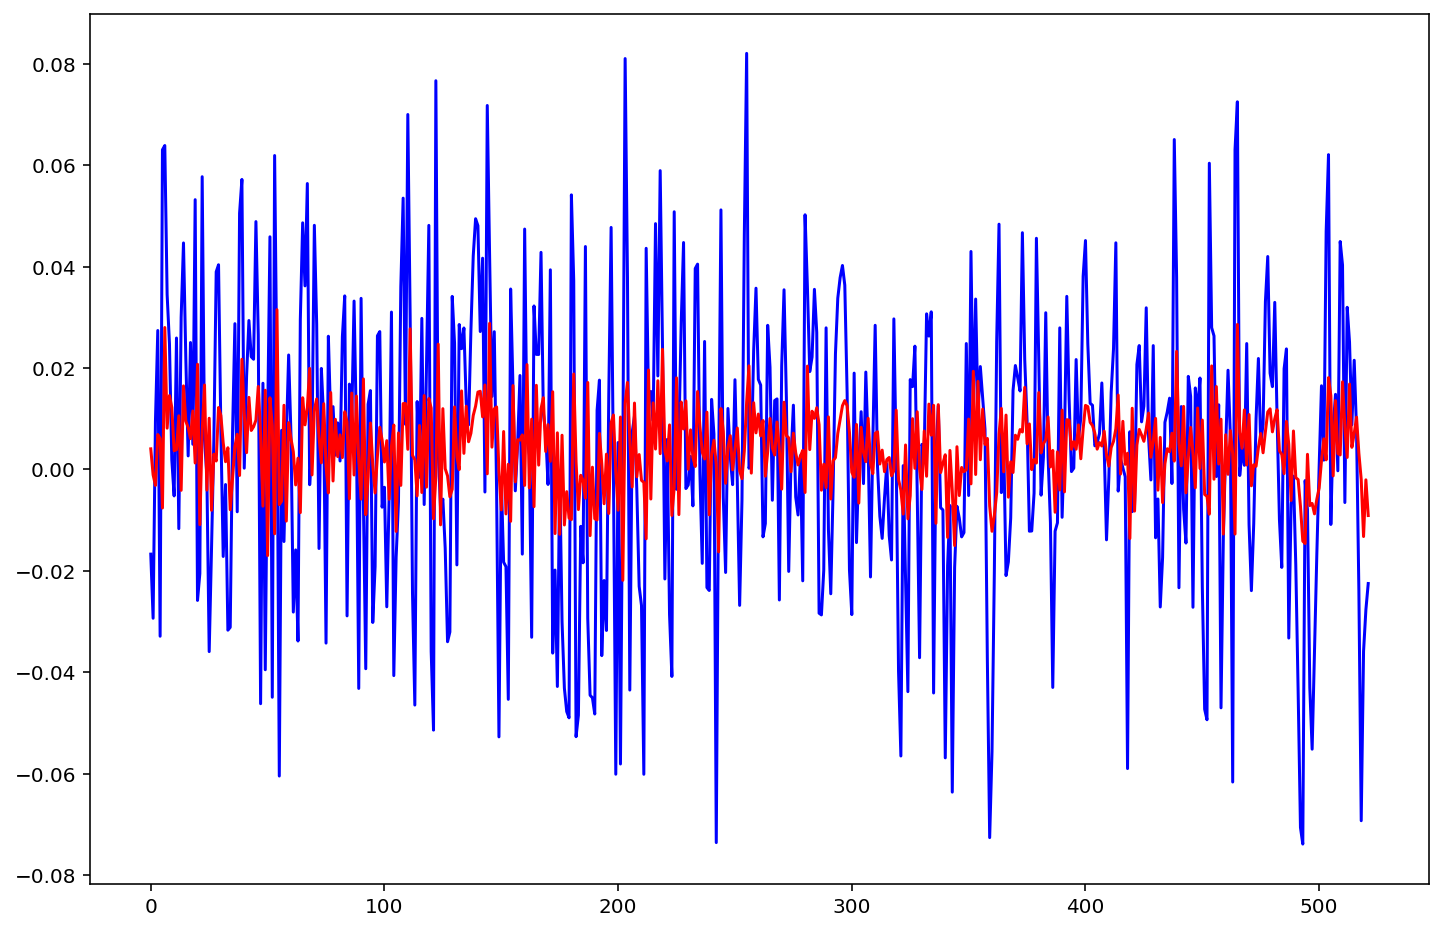

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

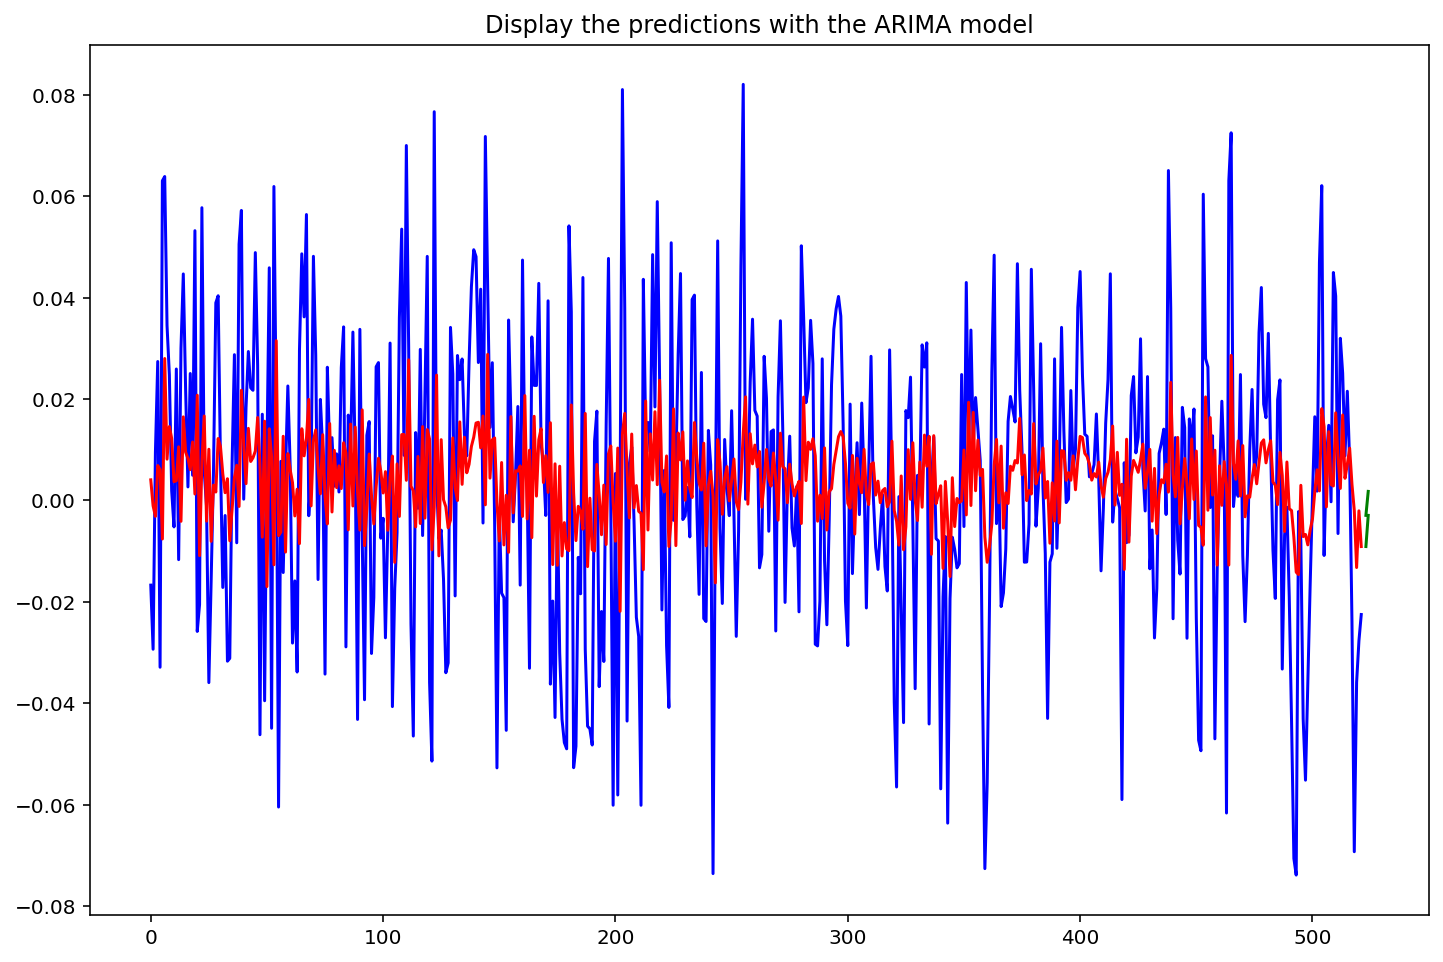

In [18]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.